fit() 함수 로그에는 기본적으로 손실값과 정확도가 표시됩니다. 이진분류 모델에서는 정확도값 하나만 보더라도 학습이 제대로 되고 있는 지 알 수 있지만, 다중클래스분류 문제에서는 클래스별로 학습이 제대로 되고 있는 지 확인하기 위해서는 정확도값 하나로는 부족함이 많습니다. 이진분류 문제에서 클래스간 불균형이 있을 경우에도 정확도값 하나로는 판단할 수가 없습니다. 본 장에서는 학습 중에 클래스별로 정밀도(precision)와 재현율(recall)을 살펴볼 수 있도록 사용자 정의 메트릭(custom metric)을 사용하는 법과 나온 결과를 시각화 하는 방법을 알아보겠습니다.

---

### 메트릭 개념

메트릭은 평가 기준을 말합니다. compile() 함수의 metrics 인자로 여러 개의 평가 기준을 지정할 수 있습니다. 이러한 평가 기준에는 모델의 학습에는 영향을 미치지 않지만, 학습 과정 중에 제대로 학습되고 있는 지 살펴볼 수 있습니다. 아래는 일반적으로 평가 기준을 'accuracy'으로 삽입하였을 때의 코드입니다.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

케라스에서는 다중클래스분류 문제에서 평가기준을 'accuracy'로 지정했을 경우 내부적으로 categorical_accuracy() 함수를 이용하여 정확도가 계산됩니다.

In [ ]:
def categorical_accuracy(y_true, y_pred):
    return K.cast(K.equal(K.argmax(y_true, axis=-1),
                          K.argmax(y_pred, axis=-1)),
                  K.floatx())

이런 평가 기준을 정의하는 함수는 두 개의 인자를 받습니다.
* y_true: 실제 값, 티아노 및 텐스플로우의 텐서(tensor)
* y_pred: 예측 값, 티아노 및 텐스플로우의 텐서(tensor)

함수 내부는 어떻게 평가를 할 것인가를 정의합니다. 이 함수는 매 배치때마다 호출되며 입력되는 데이터들에 대해 평가를 수행한 후 그 결과의 평균을 하나의 텐서로 반환합니다.

---

### 사용자 정의 메트릭

케라스에서 제공하는 함수형태와 비슷하게 사용자 정의 메트릭을 만들 수 있습니다. 아래 코드는 특정 클래스에 대한 정밀도를 평가하는 함수입니다. 여러 개의 클래스를 하나의 함수로 사용할 수 있도록 'interesting_class_id' 인자를 사용하였습니다.

In [ ]:
def single_class_precision(interesting_class_id):
    def prec(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        precision_mask = K.cast(K.equal(class_id_pred, interesting_class_id), 'int32')
        class_prec_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * precision_mask
        class_prec = K.cast(K.sum(class_prec_tensor), 'float32') / K.cast(K.maximum(K.sum(precision_mask), 1), 'float32')
        return class_prec
    return prec

분류 문제에서 클래스별로 확인할 때는 정밀도와 재현율을 파악하는 것이 도움이 됩니다. 정밀도와 재현율의 개념에 대해서는 ['평가 이야기'](https://tykimos.github.io/2017/05/22/Evaluation_Talk/)을 참고하시기 바랍니다. 아래 코드는 특정 클래스에 대한 재현율을 평가하는 함수입니다.

In [ ]:
def single_class_recall(interesting_class_id):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, interesting_class_id), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall

---

### 사용자 정의 메트릭 사용하기

사용자 정의 메트릭을 사용할 때는 compile() 함수의 metrics 인자에 함수명을 삽입합니다. 'interesting_class_id' 인자를 사용하였으므로, 클래스 인덱스를 넘기도록 합니다. 본 예제에서는 mnist을 사용하기 때문에 0~9까지로 살펴보도록 하겠습니다.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', 
              metrics=['accuracy',
                       single_class_precision(0), single_class_recall(0),
                       single_class_precision(1), single_class_recall(1),
                       single_class_precision(2), single_class_recall(2),
                       single_class_precision(3), single_class_recall(3),
                       single_class_precision(4), single_class_recall(4),
                       single_class_precision(5), single_class_recall(5),
                       single_class_precision(6), single_class_recall(6),
                       single_class_precision(7), single_class_recall(7),
                       single_class_precision(8), single_class_recall(8),
                       single_class_precision(9), single_class_recall(9)])

---

### 학습과정 살펴보기

fit() 함수는 히스토리 객체를 반환하는 데, 이 객체에는 매 에포크마다 prec_1, prec_2, prec_3... prec_10과 recall_1, recall_2, recall_3... recall_10의 값을 가지고 있습니다.

In [ ]:
hist = model.fit(x_train, y_train, epochs=5, batch_size=32)

메트릭을 여러개 지정할 경우 아래와 같이 fit() 함수 실행 시 로그에도 여러 개의 메트릭이 표시됩니다. 동시에 여러 수치가 올라가는 것을 보고있노라면 마치 참새가 재잘거리는 소리가 들리는 것 같군요.

![img](https://tykimos.github.io/warehouse/2017-9-24-Custom_Metric_log.gif)

이 값을 시각화하는 코드는 다음과 같습니다.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['prec_1'], label='precision 1')
plt.plot(hist.history['prec_2'], label='precision 2')
plt.plot(hist.history['prec_3'], label='precision 3')
plt.plot(hist.history['prec_4'], label='precision 4')
plt.plot(hist.history['prec_5'], label='precision 5')
plt.plot(hist.history['prec_6'], label='precision 6')
plt.plot(hist.history['prec_7'], label='precision 7')
plt.plot(hist.history['prec_8'], label='precision 8')
plt.plot(hist.history['prec_9'], label='precision 9')
plt.plot(hist.history['prec_10'], label='precision 10')
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(loc='lower right')
plt.show()

![img](https://tykimos.github.io/warehouse/2017-9-24-Custom_Metric_output_23_1.png)

In [ ]:
plt.plot(hist.history['recall_1'], label='recall 1')
plt.plot(hist.history['recall_2'], label='recall 2')
plt.plot(hist.history['recall_3'], label='recall 3')
plt.plot(hist.history['recall_4'], label='recall 4')
plt.plot(hist.history['recall_5'], label='recall 5')
plt.plot(hist.history['recall_6'], label='recall 6')
plt.plot(hist.history['recall_7'], label='recall 7')
plt.plot(hist.history['recall_8'], label='recall 8')
plt.plot(hist.history['recall_9'], label='recall 9')
plt.plot(hist.history['recall_10'], label='recall 10')
plt.xlabel('epoch')
plt.ylabel('recall')
plt.legend(loc='lower right')
plt.show()

![img](https://tykimos.github.io/warehouse/2017-9-24-Custom_Metric_output_23_2.png)

---

### 메트릭을 이용한 평가결과 살펴보기

evaluate() 함수는 손실값 및 메트릭 값을 반환하는 데, 여러 메트릭을 정의 및 등록하였으므로, 여러 개의 메트릭 값을 얻을 수 있습니다.

In [ ]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)

아래는 평가를 통해 얻은 메트릭 값을 시각화하는 코드입니다. 클래스별로 정밀도와 재현율을 막대그래프로 표시해봤습니다.

In [ ]:
import numpy as np

metrics = np.array(loss_and_metrics[2:])
idx = np.linspace(0, 19, 20) 
precision = metrics[(idx % 2) == 0]
recall = metrics[((idx+1) % 2) == 0]

import matplotlib.pyplot as plt

N = 10
ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots()
prec_bar = ax.bar(ind, precision, width, color='r')
recall_bar = ax.bar(ind + width, recall, width, color='y')

ax.set_ylabel('Scores')
ax.set_title('Precision and Recall')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10'))

ax.legend((prec_bar[0], recall_bar[0]), ('Precision', 'Recall'))

plt.show()

![img](https://tykimos.github.io/warehouse/2017-9-24-Custom_Metric_output_23_4.png)

---

### 전체 소스코드

전체 소스코드는 다음과 같습니다. 기본적인 mnist 예제에서 사용자 정의 메트릭 정의 및 등록과 시각화 하는 부분이 추가되었습니다.

Epoch 1/5
60000/60000 [==============================] - 7s - loss: 0.6639 - acc: 0.8324 - prec_1: 0.8705 - recall_1: 0.9026 - prec_2: 0.8434 - recall_2: 0.8951 - prec_3: 0.8080 - recall_3: 0.7866 - prec_4: 0.7888 - recall_4: 0.7829 - prec_5: 0.7889 - recall_5: 0.8232 - prec_6: 0.7472 - recall_6: 0.6403 - prec_7: 0.8516 - recall_7: 0.8736 - prec_8: 0.8397 - recall_8: 0.8406 - prec_9: 0.7332 - recall_9: 0.7501 - prec_10: 0.7570 - recall_10: 0.7301     
Epoch 2/5
60000/60000 [==============================] - 7s - loss: 0.3468 - acc: 0.9031 - prec_1: 0.9029 - recall_1: 0.9249 - prec_2: 0.9138 - recall_2: 0.9442 - prec_3: 0.8696 - recall_3: 0.8409 - prec_4: 0.8610 - recall_4: 0.8441 - prec_5: 0.8648 - recall_5: 0.8857 - prec_6: 0.8236 - recall_6: 0.8028 - prec_7: 0.8917 - recall_7: 0.9036 - prec_8: 0.8961 - recall_8: 0.8888 - prec_9: 0.8348 - recall_9: 0.8321 - prec_10: 0.8462 - recall_10: 0.8455     
Epoch 3/5
60000/60000 [==============================] - 7s - loss: 0.3002 - acc: 0.9155

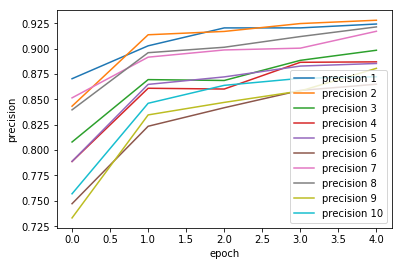

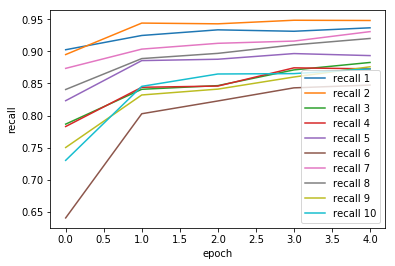

 9664/10000 [===========================>..] - ETA: 0s## evaluation loss and_metrics ##
[0.23389623485803604, 0.93569999999999998, 0.93501714344024656, 0.96290285758972172, 0.95712000045776369, 0.95975619077682495, 0.91664761981964116, 0.90009523944854741, 0.90259047775268553, 0.92727619199752809, 0.886011429977417, 0.91370666770935061, 0.87623619136810305, 0.85451682758331304, 0.92037333421707157, 0.92180571537017819, 0.9204723814964294, 0.90364190587997439, 0.90296889028549199, 0.89279238224029545, 0.88955913543701171, 0.87660952548980708]


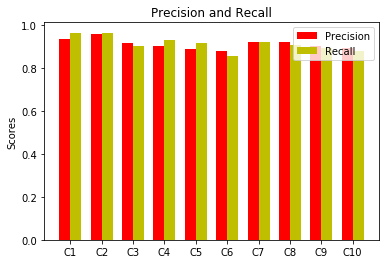

In [3]:
# 0. 사용할 패키지 불러오기
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation

from keras import backend as K

# 특정 클래스에 대한 정밀도
def single_class_precision(interesting_class_id):
    def prec(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        precision_mask = K.cast(K.equal(class_id_pred, interesting_class_id), 'int32')
        class_prec_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * precision_mask
        class_prec = K.cast(K.sum(class_prec_tensor), 'float32') / K.cast(K.maximum(K.sum(precision_mask), 1), 'float32')
        return class_prec
    return prec

# 특정 클래스에 대한 재현율
def single_class_recall(interesting_class_id):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, interesting_class_id), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall

# 1. 데이터셋 생성하기
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(units=64, input_dim=28*28, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='sgd', 
              metrics=['accuracy',
                       single_class_precision(0), single_class_recall(0),
                       single_class_precision(1), single_class_recall(1),
                       single_class_precision(2), single_class_recall(2),
                       single_class_precision(3), single_class_recall(3),
                       single_class_precision(4), single_class_recall(4),
                       single_class_precision(5), single_class_recall(5),
                       single_class_precision(6), single_class_recall(6),
                       single_class_precision(7), single_class_recall(7),
                       single_class_precision(8), single_class_recall(8),
                       single_class_precision(9), single_class_recall(9)])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=5, batch_size=32)

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['prec_1'], label='precision 1')
plt.plot(hist.history['prec_2'], label='precision 2')
plt.plot(hist.history['prec_3'], label='precision 3')
plt.plot(hist.history['prec_4'], label='precision 4')
plt.plot(hist.history['prec_5'], label='precision 5')
plt.plot(hist.history['prec_6'], label='precision 6')
plt.plot(hist.history['prec_7'], label='precision 7')
plt.plot(hist.history['prec_8'], label='precision 8')
plt.plot(hist.history['prec_9'], label='precision 9')
plt.plot(hist.history['prec_10'], label='precision 10')
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(loc='lower right')
plt.show()

plt.plot(hist.history['recall_1'], label='recall 1')
plt.plot(hist.history['recall_2'], label='recall 2')
plt.plot(hist.history['recall_3'], label='recall 3')
plt.plot(hist.history['recall_4'], label='recall 4')
plt.plot(hist.history['recall_5'], label='recall 5')
plt.plot(hist.history['recall_6'], label='recall 6')
plt.plot(hist.history['recall_7'], label='recall 7')
plt.plot(hist.history['recall_8'], label='recall 8')
plt.plot(hist.history['recall_9'], label='recall 9')
plt.plot(hist.history['recall_10'], label='recall 10')
plt.xlabel('epoch')
plt.ylabel('recall')
plt.legend(loc='lower right')
plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

import numpy as np

metrics = np.array(loss_and_metrics[2:])
idx = np.linspace(0, 19, 20) 
precision = metrics[(idx % 2) == 0]
recall = metrics[((idx+1) % 2) == 0]

import matplotlib.pyplot as plt

N = 10
ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots()
prec_bar = ax.bar(ind, precision, width, color='r')
recall_bar = ax.bar(ind + width, recall, width, color='y')

ax.set_ylabel('Scores')
ax.set_title('Precision and Recall')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10'))

ax.legend((prec_bar[0], recall_bar[0]), ('Precision', 'Recall'))

plt.show()

---

### 요약

다중클래스분류 문제에서 클래스별로 정밀도 및 재현율을 알아보기 위해 사용자 정의 메트릭을 정의하고 등록하는 법을 알아보왔습니다. 그리고 학습 과정 및 평가 시에 산출되는 메트릭 값을 차트를 통해 시각화하는 방법에 대해서도 알아봤습니다. 이 방법들을 통해 'accuracy' 값만 보던 것을 벗어나 다양한 평가 기준으로 모델의 학습과정을 살펴보시기 바랍니다.

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/lecture/)
* [평가 이야기](https://tykimos.github.io/2017/05/22/Evaluation_Talk/)

[김태영의 책]

![img](https://tykimos.github.com/images/book_title.jpg)

[교보문고](http://www.kyobobook.co.kr/product/detailViewKor.laf?ejkGb=KOR&mallGb=KOR&barcode=9788960882133&orderClick=LAG&Kc=#N) [YES24](http://www.yes24.com/24/goods/49867702?scode=032&OzSrank=4) [반디앤루이스](http://www.bandinlunis.com/front/product/detailProduct.do?prodId=4108153) [알라딘](http://www.aladin.co.kr/shop/wproduct.aspx?ItemId=118349212) [인터파크](http://shopping.interpark.com/product/productInfo.do?prdNo=5164576976&dispNo=008001082&pis1=shop&pis2=product)

[하용호님, 카카오 데이터사이언티스트] 뜬구름같은 딥러닝 이론을 블록이라는 손에 잡히는 실체로 만져가며 알 수 있게 하고, 구현의 어려움은 케라스라는 시를 읽듯이 읽어내려 갈 수 있는 라이브러리로 풀어준다.

[이부일님, (주)인사아트마이닝 대표] 여행에서도 좋은 가이드가 있으면 여행지에 대한 깊은 이해로 여행이 풍성해지듯이 이 책은 딥러닝이라는 분야를 여행할 사람들에 가장 훌륭한 가이드가 되리라고 자부할 수 있다. 이 책을 통하여 딥러닝에 대해 보지 못했던 것들이 보이고, 듣지 못했던 것들이 들리고, 말하지 못했던 것들이 말해지는 경험을 하게 될 것이다. 

[이활석님, 네이버 클로바팀] 레고 블럭에 비유하여 누구나 이해할 수 있게 쉽게 설명해 놓은 이 책은 딥러닝의 입문 도서로서 제 역할을 다 하리라 믿습니다.

[김진중님, 야놀자 Head of STL] 복잡했던 머릿속이 맑고 깨끗해지는 효과가 있습니다.

[이태영님, 신한은행 디지털 전략부 AI LAB] 기존의 텐서플로우를 활용했던 분들에게 바라볼 수 있는 관점의 전환점을 줄 수 있는 Mild Stone과 같은 책이다.

[전태균님, 쎄트렉아이] 케라스의 특징인 단순함, 확장성, 재사용성을 눈으로 쉽게 보여주기 위해 친절하게 정리된 내용이라 생각합니다.

[유재준님, 카이스트] 바로 적용해보고 싶지만 어디부터 시작할지 모를 때 최선의 선택입니다.